# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


---
# Projet H2023 : Prédiction du prix des diamants


La description du projet est disponible à l'adresse suivante : https://www.kaggle.com/t/2126c40a2d454beb8bd36d168581c968

Ce calepin Jupyter de base permet de charger les données fournies. La dernière section détaille la génération du fichier des prédictions afin de le soumettre sur Kaggle dans le bon format.

### Données

Dans un premier temps, vous devrez récupérer les données sur Kaggle. Les fichiers disponibles sont les suivants :
- train.csv
- test.csv

**Déposez ces fichiers dans le répertoire de ce calepin.**

Le fichier *train.csv* contient le prix de vente en dollar américain de 40 455 diamants en fonction des caractéristiques suivantes :

- cut : qualité de coupe (Fair, Good, Very Good, Premium, Ideal)
- color : couleur du diamant (de J (pire) à D (meilleure)
- clarity : clarté du diamant (I1 (pire), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (meilleure))
- x: longueur en mm 
- y: largeur en mm
- z: profondeur en mm
- depth: pourcentage de la profondeur exprimée comme 2*z/(x+y)
- table: pourcentage de la largeur du sommet du diamant par rapport au point le plus large 

Le fichier test.csv contient les caractéristiques de 13 485 diamants pour lesquels vous devriez prédire le prix de vente. La qualité de vos prédictions sera ensuite évaluée lorsque vous les téléverserez sur Kaggle. Vos prédictions seront comparées à celles des autres équipes de la classe.


### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre identifiant d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul calepin *.ipynb* par équipe doit être remis. Ce fichier documente et illustre la procédure qui vous a permis de produire vos meilleures prédictions. Ce fichier constitue le rapport final du projet.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre à une personne à l'extérieur de l'équipe de comprendre votre démarche et de reproduire vos résultats. Par exemple, une bonne façon de faire consiste à expliquer dans une cellule de texte la tâche qui est accomplie dans la cellule de code suivante. 

Je vous encourage fortement à faire une analyse exploratoire des données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, comme par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se trouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin contient un modèle très simple de prédiction : on n'utilise qu'une seule variable explicative. Ce sera votre travail d'améliorer ces prédictions avec la méthode et les variables de votre choix.

S'il y a des données manquantes, ce sera à vous de traiter ce problème. Vous devriez développer une méthode d'imputation (de remplacement) des données manquantes.

Prenez la peine de documenter succinctement les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner dans la discussion avec une raison possible de leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode infructueuse déjà testée.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode a moins bien performée de ce qui était attendu. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données. L'idée est de guider l'analyste qui prendrait la relève de votre travail.

Vous êtes limités à deux soumissions par jour UTC par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs prédictions de la journée.

In [1]:
using CSV 
using DataFrames
using Distributions
using Gadfly
using LinearAlgebra
import Random
using GLM
using Statistics
import StatsBase
import Plots

---
## 1. Chargement de données

In [2]:
data = CSV.read("train.csv", DataFrame)
# first(data, 5)
first(sort(data, [:price], rev=true), 5)

Row,ID,cut,color,clarity,depth,table,price,x,y,z
,Int64,String15?,String1,String7,Float64?,Float64,Int64,Float64,Float64?,Float64
1,4422,Premium,I,VS2,60.9,60.0,18823,8.49,8.46,5.16
2,35311,Ideal,G,SI2,62.6,55.0,18804,8.2,8.13,5.11
3,11882,Premium,I,VS1,60.8,59.0,18795,8.12,8.04,4.91
4,21157,Premium,H,SI1,58.1,60.0,18795,8.37,8.3,4.84
5,8394,Ideal,G,SI2,62.7,54.0,18792,8.28,8.34,5.21


Ici, nous remplassons les valeurs de 38.1mm trouvées en x et en y par les valeurs de x de la même rangée. Ces valeu

In [3]:
test = CSV.read("test.csv", DataFrame)
println(nrow(test))
println(nrow(dropmissing(test)))

replace!(test.y, 31.8 => 5.15)
replace!(test.z, 31.8 => 5.15)

first(sort(dropmissing(test), [:y], rev=true), 15)

13485
11491


Row,ID,cut,color,clarity,depth,table,x,y,z
,Int64,String15,String1,String7,Float64,Float64,Float64,Float64,Float64
1,2601,Premium,H,I1,62.1,58.0,9.45,9.38,5.85
2,6290,Fair,H,I1,56.2,62.0,9.53,9.37,5.31
3,2118,Premium,I,SI2,60.1,59.0,9.37,9.32,5.62
4,5909,Good,I,I1,57.0,64.0,9.39,9.31,5.33
5,7997,Premium,G,I1,58.6,60.0,9.12,9.06,5.33
6,5070,Fair,I,I1,65.2,56.0,9.11,9.02,5.91
7,9781,Premium,I,SI2,61.1,59.0,9.04,8.97,5.5
8,5773,Fair,I,SI2,65.7,56.0,9.0,8.95,5.9
9,5054,Premium,J,SI2,59.4,58.0,8.86,8.83,5.25


#### 1.1 Retirer les valeurs aberrantes de l'entrainement
A cette étape, nous supprimons les valeurs aberrantes du dataset que nous nous appretons à utiliser (valeurs beaucoup trop grandes, tailles négatives,...) pour l'entrainement du modèle. Cela permet d'éviter que le modèle s'entraine sur des données tronquées et qui pourraient biaiser nos futurs estimations.


In [4]:
println("Avec valeurs aberrantes: $(nrow(data))")
filter!((:x) => (x) -> (3 < x), data)
filter!((:y) => (y) -> ismissing(y) || (0 < y && y < 9.5), data)
filter!((:z) => (z) -> (2 < z && z < 6), data)
println("Sans valeurs aberrantes: $(nrow(data))")

Avec valeurs aberrantes: 40455
Sans valeurs aberrantes: 40425


---
## 2. Analyse exploratoire

Cette section consitue une analyse exploratoire superficielle permettant de se familiariser avec les données. C'est une analyse exploratoire sommaire. Je vous encourage fortement à poursuivre cette analyse.

In [6]:
describe(data)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,ID,20228.3,1,20228.0,40455,0,Int64
2,cut,,Fair,,Very Good,3804,"Union{Missing, String15}"
3,color,,D,,J,0,String1
4,clarity,,I1,,VVS2,0,String7
5,depth,61.7475,42.2,61.8,100.5,2199,"Union{Missing, Float64}"
6,table,57.4649,43.0,57.0,95.0,0,Float64
7,price,3934.35,326,2402.0,18823,0,Int64
8,x,5.73137,3.73,5.7,9.5,0,Float64
9,y,5.7329,3.67,5.71,9.46,2199,"Union{Missing, Float64}"


#### 2.1 Prix en fonction de la clarté

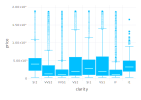

In [7]:
plot(data, x=:clarity, y=:price, Geom.boxplot)

In [8]:
Cette étape nous permet de voir l'intervalle de prix qu'un diamant peut avoir a une clarté donnée. Cela peut être utile pour entrainer le modèle.

LoadError: syntax: extra token "étape" after end of expression

#### 2.2 Distribution des prix

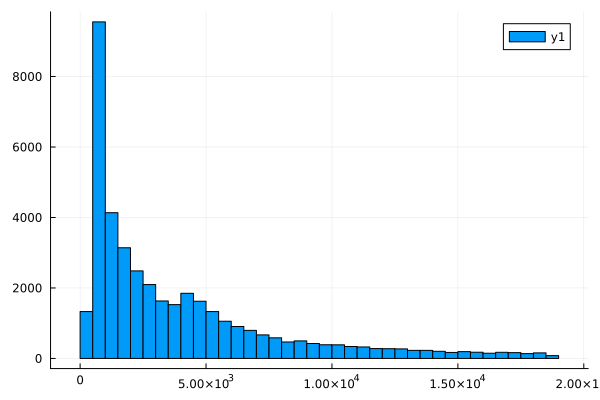

In [9]:
Plots.histogram(data.price)

Nous observons ici que la distribution des prix est distribuée selon une loi de poisson. Cela s'explique par le fait que les meilleurs diamants sont aussi les plus rares, et donc que leur prix est plus élevé.

#### 2.3 Distribution des y

min y = 3.67, max y = 9.46


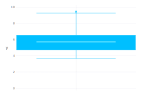

In [10]:
data_without_missing_y = dropmissing(data, :y, disallowmissing=true)
println("min y = $(minimum(data_without_missing_y.y)), max y = $(maximum(data_without_missing_y.y))")


plot(data_without_missing_y, y=:y, Geom.boxplot)

#### 2.4 Affichage de la matrice de covariance

Cette matrice nous permet de savoir quels sont les variables qui ont le plus d'importance dans le prix final du diamant. Dans ce cas précis, il s'agit des variables X, Y et Z

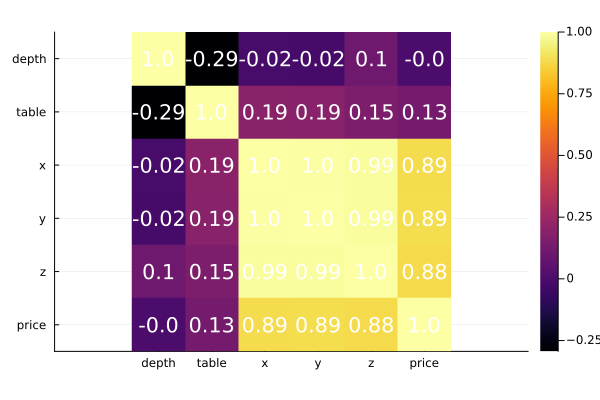

In [11]:
# https://goropikari.github.io/PlotsGallery.jl/src/heatmap.html
labels = [:depth, :table, :x, :y, :z, :price]
# cor(Matrix(select(data, [:table, :x, :z, :price])))
correlation = cor(Matrix(dropmissing(select(data, labels))))
# cor(Matrix(dropmissing(select(data, [:x, :z, :chart, :color_num, :clarity_num, :price]))))

Plots.heatmap(correlation, yflip=true, xticks=(1:6, labels), yticks=(1:6, labels), aspect_ratio=:equal)

ann = [(i,j, Plots.text(round(correlation[i,j], digits=2), :white, :center)) for i in 1:6 for j in 1:6]
Plots.annotate!(ann, linecolor=:white)



---
## 3. Ajustement d'un modèle de régression linéaire

#### Séparer les données en ensemble d'entrainement/de validation

In [12]:
Random.seed!(3302)

ntrain = round(Int, 0.95 * nrow(data))

train_id = sample(1:nrow(data), ntrain, replace=false, ordered=true)
valid_id = setdiff(1:nrow(data), train_id)

train = data[train_id, :]
valid = data[valid_id, :]

first(train, 5)

Row,ID,cut,color,clarity,depth,table,price,x,y,z
,Int64,String15?,String1,String7,Float64?,Float64,Int64,Float64,Float64?,Float64
1,1,missing,E,SI2,60.2,60.0,5340,6.46,6.5,3.9
2,2,Ideal,G,VVS2,62.7,57.0,1936,5.12,5.05,3.19
3,3,Premium,E,VVS1,62.0,59.0,1012,4.33,4.28,2.67
4,4,Ideal,G,VS2,61.7,57.0,720,4.41,4.38,2.71
5,5,missing,G,VS2,62.4,58.0,6301,6.41,6.48,4.02


In [13]:
nrow(data), nrow(train), nrow(valid)

(40425, 38404, 2021)

In [25]:
function plot_predictions(predictions, real_price)
    df = DataFrame(predictions=predictions, real_price=real_price)
    sort!(df, [:predictions])
    # sort!(df, [:real_price])

    range = 1:length(predictions)

    Plots.plot(range, df.real_price[range], seriestype=:scatter, color=:red, label="vérité")
    Plots.plot!(range, df.predictions[range], seriestype=:scatter, color=:blue, label="prédiction")
    # Plots.xlabel!("# rangée (en ordre croissant de prédiction de prix)")
    Plots.ylabel!("prix")
end

plot_predictions (generic function with 2 methods)

#### 3.3 Prédire les y avec une loi linéaire généralisée gamma

Nous avions précedemment remarqué que le dans le dataset d'entrainemment plusieurs valeurs de Y n'étaient pas présentes, nous avons aisni décidé de prédire celles manquantes. Les données sur la taille des diamants sont extrèmement importantes, il vaut mieux en avoir le plus possible.

In [26]:
y_model = glm(@formula(y ~ color * clarity * table * x * z), train, Gamma(), InverseLink())
train.y = coalesce.(train.y, predict(y_model, train))
valid.y = coalesce.(valid.y, predict(y_model, valid))
test.y = coalesce.(test.y, predict(y_model, test))

y_known = dropmissing(train, :y)
y_predictions = predict(y_model, y_known)
y_predictions = collect(skipmissing(y_predictions))

rmse = StatsBase.rmsd(y_known.y, y_predictions)
println("rmse = $(rmse)")


LoadError: type NamedTuple has no field table

La prédictions de y ont un RMSE de 0.065, nous avons donc réussi à prédire les valeurs de Y avec une très bonne précision, cela nous sera utile pour l'entrainement final du modele.

Ainsi, le modèle se base sur la couleur, la clareté, et les dimensions du diamant pour prédire son prix :

In [27]:
model = glm(@formula(price ~ color * clarity * x * y * z), train, Poisson(), LogLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Poisson{Float64}, LogLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

price ~ 1 + color + clarity + x + y + z + color & clarity + color & x + clarity & x + color & y + clarity & y + x & y + color & z + clarity & z + x & z + y & z + color & clarity & x + color & clarity & y + color & x & y + clarity & x & y + color & clarity & z + color & x & z + clarity & x & z + color & y & z + clarity & y & z + x & y & z + color & clarity & x & y + color & clarity & x & z + color & clarity & y & z + color & x & y & z + clarity & x & y & z + color & clarity & x & y & z

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                             Coef.  Std. Error       z  Pr(>|z|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────

Extraction de l'estimation des coefficients :

In [28]:
β̂ = coef(model)

448-element Vector{Float64}:
   3.345715263258662
  -5.905234012066592
   7.625976334665208
 -15.000021250871265
 -11.434282403120072
   2.247395186128479
 -61.375017486401816
 -29.96057219318771
  -0.06325430129449523
  -3.788255019315215
   4.849093414581052
   7.1937082048651275
  -2.3478489044301813
   ⋮
  -0.09838056357217036
  -0.05803136828680918
  -0.12965156147059526
  -0.09610766942629112
  -0.0156727418364843
  -0.23759305056981403
   0.00987745513436295
   0.09794237823187575
   0.023526003668205307
   0.04396312725510307
   0.14358559975848523
  -0.10188717626193365

#### 3.2. Validation graphique

Pour avoir un aperçu de la qualité de la regression, on ajoute la droite de régression.

---
## 4. Estimation du prix de diamants sur les différents ensembles


Dans cette section, nous prédisons la valeur des prix avec le dataset d'entrée, nous arrondissons les résultats obtenus puis nous limitons l'apparition de valeurs aberrantes en utilisant la fonction clamp() sur les ensembles de test et de validation. 

Nous répétons cette étape sur les 3 dataset

#### 4.1 Prédiction et rmse de l'ensemble d'entrainement

In [29]:
train_predictions = predict(model, train)
train_predictions = round.(Int, train_predictions)

rmse = StatsBase.rmsd(train_predictions, train.price)

597.5200151443239

#### 4.2 Prédiction et rmse de l'ensemble de validation

In [30]:
select!(valid, [:color, :clarity, :x, :y, :z, :price])

valid_predictions = predict(model, valid)
valid_predictions = round.(Int, predictions)
clamp!(valid_predictions, minimum(data.price), maximum(data.price))

rmse = StatsBase.rmsd(valid_predictions, valid.price)

LoadError: UndefVarError: predictions not defined

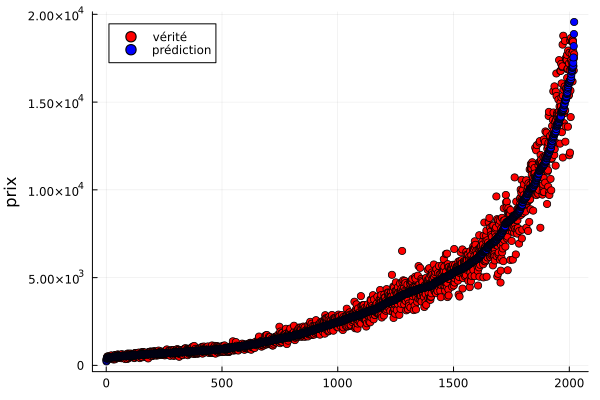

In [31]:
plot_predictions(valid_predictions, valid.price)

#### 4.3 Prédiction et rmse de l'ensemble de test

In [32]:
test_predictions = predict(model, test)
test_predictions = round.(Int, test_predictions)
test.price = test_predictions

first(sort(test, [:y], rev=false), 5)

Row,ID,cut,color,clarity,depth,table,x,y,z,price
,Int64,String15?,String1,String7,Float64?,Float64,Float64,Float64,Float64,Int64
1,7998,Very Good,H,VS2,-0.0,53.0,0.01,-0.03,0.0,1
2,12219,Premium,D,VVS1,-0.0,59.0,-0.0,-0.01,0.0,3
3,2381,Good,F,SI2,0.0,60.0,0.01,0.01,0.0,0
4,3754,Good,F,SI2,0.0,60.0,0.01,0.01,0.0,0
5,9220,Very Good,E,VS2,63.4,54.0,3.8,3.77,2.4,479


In [33]:
outliers = filter((:price) => price -> price < minimum(data.price) || price > maximum(data.price), test)
clamp!(test_predictions, 0, maximum(data.price))
outliers

Row,ID,cut,color,clarity,depth,table,x,y,z,price
,Int64,String15?,String1,String7,Float64?,Float64,Float64,Float64,Float64,Int64
1,201,Premium,H,VS1,60.9,59.0,8.61,8.59,5.24,23413
2,467,Very Good,F,SI2,63.4,56.0,8.64,8.55,5.45,20830
3,711,missing,J,VS1,59.6,60.0,8.73,8.76,5.21,19437
4,1077,Premium,F,SI1,61.3,59.0,8.14,8.23,5.02,18947
5,1756,Good,D,IF,61.7,63.0,6.64,6.75,4.13,22283
6,2118,Premium,I,SI2,60.1,59.0,9.37,9.32,5.62,19515
7,2381,Good,F,SI2,0.0,60.0,0.01,0.01,0.0,0
8,2867,missing,F,SI2,62.6,59.0,8.51,8.43,5.3,18872
9,3690,Ideal,G,VS2,61.8,57.0,8.25,8.17,5.07,18973


#### 4.4 Préparation du fichier des préditions pour téléverser sur Kaggle

Le fichier *benchmark_predictions.csv* généré peut être téléversé sur Kaggle. Il est composé d'une colonne d'identifiants (:ID) et d'une colonne de la prédiction des prix (:price).

In [34]:
benchmark_predictions = DataFrame(ID = test.ID, price=test_predictions)
first(benchmark_predictions, 5)

Row,ID,price
,Int64,Int64
1,1,5585
2,2,2803
3,3,2340
4,4,413
5,5,15477


In [35]:
CSV.write("benchmark_predictions.csv", benchmark_predictions)

"benchmark_predictions.csv"

#### 5 - Pistes explorées

Durant le projet nous avons essayé d'implémenter la méthode KNN mais également un SVR (Support Vector Regression), ce dernier modèle nous a permis d'atteindre un RMSE de 584 sur Kaagle, mais la limite de tentative journalière nous en à empecher.